<a id="top"></a>
# Vegetation Change

<hr>

# Notebook Summary

This notebook uses changes in the Normalized Difference Vegetation Index (NDVI) to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral index in each of those time periods. Significant changes in NDVI (vegetation greenness) are coincident with land change, as long as the comparisons are done between similar time periods (seasons or years). Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. It is expected that this algorithm can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments. In some cases the impacts may be negative (deforestation, mining, burning, drought) or positive (regrowth, improved soil moisture).

It should also be noted that the selection of the baseline and analysis time period is critical. First, the two time periods should be similar (season, year) so that the vegetation state can be compared in similar weather conditions. Second, the time periods should be sufficiently clear (non-cloudy). If the baseline or analysis mosaic (composite of images) is contaminated with clouds, it will impact the results. The more cloud cover over an area, the less accurate this analysis will be for that area. In the extreme case of pixels with cloud cover for all time slices in the time range, no vegetation change information will be available for those pixels.

<hr>

# Index  

* Import Dependencies and Connect to the Data Cube
* Choose Platform and Product
* Get the Maximum Extents of the Cube
* Define the Analysis Parameters
* Load Data from the Data Cube
* Create a Mosaic for the Baseline and Analysis Time Periods
* Calculate Anomaly Product
* Show Baseline RGB, Analysis RGB and Anomaly Products
* Calculate Pixel Counts within Thresholds

## Import Dependencies and Connect to the Data Cube

In [1]:
import warnings
# Supress Warning 
warnings.filterwarnings('ignore')

import numpy as np

import datacube
import utils.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## Choose Platform and Product

In [2]:
# Get available products
products_info = dc.list_products()
products_info

,name,description,format,platform,label,creation_time,lon,time,lat,instrument,product_type,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,GeoTiff,LANDSAT_7,None,None,None,None,None,ETM,LEDAPS,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Level2 Surface Ref...,GeoTiff,LANDSAT_8,None,None,None,None,None,OLI_TIRS,LaSRC,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"


In [3]:
# List LANDSAT 7 products (remove comments below to see list of products)
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [4]:
# List LANDSAT 8 products (remove comments below to see list of products)
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


In [5]:
# Select a Product and Platform
# Landsat-8 data is much better than Landsat-7 due to issues with "banding".

product = "ls7_usgs_sr_scene"
platform = "LANDSAT_7"

product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8"

## Get the Maximum Extents of the Cube

In [6]:
from utils.dc_load import get_product_extents
from utils.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.63361111121218, 18.40166666681388)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-27']


## Define the Analysis Parameters

**Area and Time**

In [7]:
# Select an analysis area and time.
# The time string format is 'YYYY/MM/DD'.
# These time windows will be used to make a mosaic, so typically pick a year length (or more)
# or select a small window surrounding a clear single date 
# (use the DCAL Cloud Statistics notebook).
# Also, be sure to evaluate the RGB mosaics (below) to affirm they are not full of clouds.

# Mau Forest - Western Kenya
# Baseline = 5/30/2013, Analysis = 5/25/2017
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)
# baseline_time_period = ('2013/12/23', '2013/12/24')
# analysis_time_period = ('2019/1/5', '2019/1/7')

# Mining Region near Obuasi, Ghana (small region)
# Baseline = 12/23/13, Analysis = 1/6/19
latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)
time_periods = {'baseline': ('2013/12/23', '2013/12/24'),
                'analysis': ('2016/1/1', '2016/12/31')}

**Mosaic Function**

In [8]:
# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
# Use "median" for longer time periods, such as a year
# Use "most_recent_pixel" for short time periods, such as one day
# Use "max_ndvi" for seasonal time periods to compare vegetation peaks
mosaic_function = "median"

In [9]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

## Load Data from the Data Cube

In [10]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
common_load_params = dict(latitude=latitude,
                      longitude=longitude,
                      platform=platform,
                      product=product,
                      measurements = measurements,
                      group_by='solar_day', dask_chunks={'time':1})

In [11]:
from utils.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

datasets = {}
clean_masks = {}
for time_period_name in time_periods:
    dataset = dc.load(**common_load_params,
                      time=time_periods[time_period_name]).compute()
    assert len(dataset.dims) > 0, \
        f"The dataset for the {time_period_name} time period is empty."
    # Get the clean masks.
    clean_mask = landsat_qa_clean_mask(dataset, platform) & \
                 (dataset != -9999).to_array().all('variable') & \
                 landsat_clean_mask_invalid(dataset)
    # Remove the 'pixel_qa' band since we have the clean mask.
    dataset = dataset.drop('pixel_qa')
    dataset = dataset.astype(np.float32).where(clean_mask)
    datasets[time_period_name] = dataset
    clean_masks[time_period_name] = clean_mask

In [12]:
# from utils.clean_mask import landsat_qa_clean_mask

# cloud_mask_baseline = landsat_qa_clean_mask(baseline_ds, platform=platform)
# baseline_ds = baseline_ds.where(cloud_mask_baseline)

# cloud_mask_analysis = landsat_qa_clean_mask(analysis_ds, platform=platform)
# analysis_ds = analysis_ds.where(cloud_mask_analysis)

## Create a Mosaic for the Baseline and Analysis Time Periods

In [13]:
from utils.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
mosaic_function_dict = {"median": create_median_mosaic,
                        "max_ndvi": create_max_ndvi_mosaic,
                        "most_recent_pixel": create_mosaic}
compositor = mosaic_function_dict[mosaic_function]

In [14]:
composites = {}
for time_period_name in time_periods:
    composites[time_period_name] = compositor(datasets[time_period_name], 
                                              clean_masks[time_period_name].values)

## Calculate Anomaly Product

In [15]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [16]:
for time_period_name in time_periods:
    composites[time_period_name]['vegetation'] = NDVI(composites[time_period_name])
vegetation_anomaly = composites['analysis']['vegetation'] - composites['baseline']['vegetation']

## Show Baseline RGB, Analysis RGB and Anomaly Products

In [17]:
import matplotlib.pyplot as plt
from utils.dc_rgb import rgb
from matplotlib.cm import RdYlGn
RdYlGn.set_bad('black',1.)

In [18]:
# Define the significant anomaly range for Plot #4
loss_range  = vegetation_anomaly < -0.2
gain_range  = vegetation_anomaly > 0.2

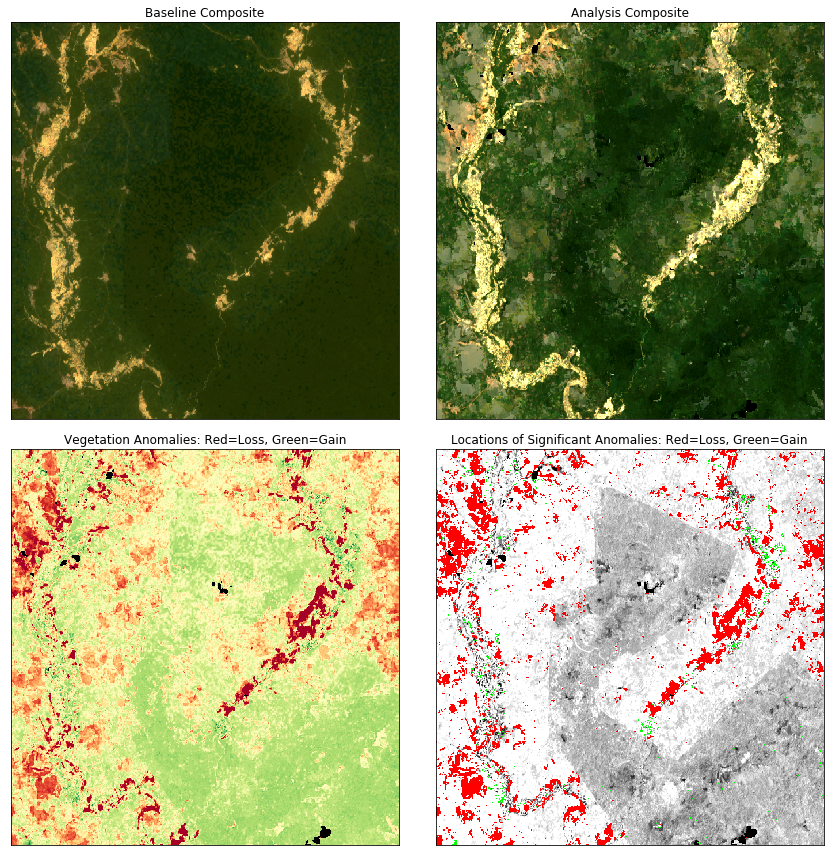

In [19]:
import xarray as xr
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12,12))

for sub_ax in ax.flatten():
    sub_ax.set_facecolor('black')

baseline_rgb = composites['baseline'][['red', 'green', 'blue']].to_array()
analysis_rgb = composites['analysis'][['red', 'green', 'blue']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values,analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values,analysis_rgb.quantile(up_qtl).values)

# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold
# NOTE: Clouds in either the baseline or analysis images will be removed from the anomaly product

## Plot #1 = Baseline RGB (upper left)
axes_image = baseline_rgb.plot.imshow(ax=ax[0,0], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #3 = Total Anomaly (lower left)
vegetation_anomaly.plot(ax=ax[1,0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(composites['analysis'][plt4_bkg_band].where(clean_masks['baseline'].squeeze('time'))\
                     .values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background (vs. 0.02 and 0.98)
min_bkg = np.nanquantile(composites['analysis'][plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(composites['analysis'][plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Significant anomaly color overlays
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(composites['analysis'].coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr,name='rgb',dims=['rgb'],coords={'rgb': rgb_coord_arr})
plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, coords=plt4_coords,dims=list(composites['analysis'].dims) + ['rgb'])
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Calculate Pixel Counts within Thresholds

In [20]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [21]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)
# This code block can be used for either vegetation loss or vegetation gain calculations

# NDVI losses might use the following limits: min=-1.0 and max=-0.2
# NDVI gains might use the following limits: min=0.2, max=1.0

minimum_change = -0.7
maximum_change = -0.2

In [22]:
# This output is a count of the pixels that fall within each threshold range

threshold_count(vegetation_anomaly,minimum_change,maximum_change)

{'total': 410466,
 'total_non_cloudy': 409411,
 'inside': 34403,
 'outside': 375008}

In [23]:
# This output is a percentage of the pixels that fall within each threshold range

threshold_percentage(vegetation_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 8.3814493770495,
 'percent_outside_threshold': 91.36152568056794,
 'percent_clouds': 0.25702494238255724}